# Southern Ocean Argo temperature profile classification

This example code illustrates how to apply Gaussian mixture modelling (GMM), an unsupervised classifcation method, to Southern Ocean Argo float temperature profile data. We discuss this approach in detail in this paper:

https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2018JC014629

This example code illustrates how to read in the temperature data and fit a Gaussian mixture model to the data.



### Import modules

Here we use scikit-learn (sklearn), matplotlib, pandas, and numpy

In [1]:
from sklearn import mixture
from sklearn import preprocessing
from sklearn.decomposition import PCA
from matplotlib.pyplot import cm
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np

### Load temperature profile data into a pandas dataframe

Uncomment the 'read_csv' line below that corresponds to the dataset that you want to try to cluster.

Pressures are in dbar (vertical coordinate), latitudes and longitudes are in degrees, and temperatures are in °C

In [2]:
#  use the pandas function 'read_csv' to create a 
#df = pd.read_csv('Argo_T_profiles_full_dataset.csv')        # 100% of profiles 
#df = pd.read_csv('Argo_T_profiles_small_subset.csv')        # 10% of profiles
df = pd.read_csv('Argo_T_profiles_very_small_subset.csv')    # recommended (1% of profiles)

# get the pressures on which the temperature readings are defined
pressures = df.columns[2:].values

# convert pressures to array of floats for plotting later
p = np.asarray([float(i) for i in pressures])

# get the latitudes, and longitudes for each profile
lon = df.iloc[:,0].values
lat = df.iloc[:,1].values

# get the array that will be used to fit the GMM object
X = df.iloc[:,2:].values

### Standardise the data

Each pressure level is treated as a different variable;we standardize the data at each pressure.

In [3]:
# by variable
Xscaled = preprocessing.scale(X)

### Use principal component analysis for dimensionality reduction

This step helps improve the performance and convergence behaviour of the algorithm

In [4]:
# create PCA object
pca = PCA(n_components=6)

# fit PCA model
pca.fit(Xscaled)

# transform input data into PCA representation
Xpca = pca.transform(Xscaled)

### Calculate BIC score to estimate number of clusters

The "best" Gaussian mixture model features the minimum BIC score. Note that there are many other ways to justify choices when it comes to the number of classes.

In [5]:
lowest_bic = np.infty
bic = []
n_components_range = range(2, 40)
cv_types = ['full']
for cv_type in cv_types:
    for n_components in n_components_range:
        # fit a Gaussian mixture model
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
        gmm.fit(Xpca)
        bic.append(gmm.bic(Xpca))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

### Plot BIC scores 

Ideally, we would have a clear minimum. Note that the number of classes may vary with different iterations, as it is somewhat sensitive to the initial guesses. In a more rigourous application, one would calculate BIC many times using different subsets to estimate the error/variation in BIC associated with the initialisation.

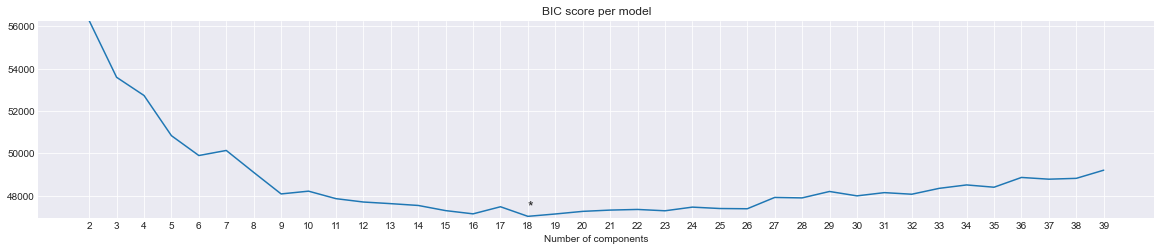

Number of classes with minimum BIC score
18


In [6]:
# later, just do a very simple bic plot
bic = np.array(bic)

# plot the BIC scores
plt.figure(figsize=(20, 8))
plt.style.use('seaborn-darkgrid')
spl = plt.subplot(2, 1, 1)
plt.plot(n_components_range,bic)
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')
xpos = np.where(bic == np.amin(bic))[0][0] + n_components_range[0]
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
plt.show()

# numbers of components
n_comp = best_gmm.n_components

# print best number of classes
print('Number of classes with minimum BIC score')
print(n_comp)

### Assign class labels to each profile based on the best GMM

This is where the actual classification occurs.

In [7]:
# assign class labels ("predict" the class using the selected GMM)
labels = best_gmm.predict(Xpca)

# find posterior probabilities (the probabilities of belonging to each class)
posterior_probs = best_gmm.predict_proba(Xpca)

# maximum posterior probability (the class is assigned based on this value)
max_posterior_probs = np.max(posterior_probs,axis=1) 

# put the labels and maximum posterior probabilities back in original dataframe
df.insert(2,'label',labels,True)
df.insert(3,'max posterior prob',max_posterior_probs,True) 

### Use pandas to calculate properties of the profiles by class assignment

In [8]:
# group profiles according to label
grouped_unsorted = df.groupby('label')

# calculate mean of all profiles in each class
df_means = grouped_unsorted.mean()

### Sort the labels based on mean near-surface temperatures

In [9]:
# extrat sea surface temperatures (SSTs)
T15_means = df_means['15.0'].values

# sort mean temperatuer at 15 dbar from coldest to warmest
old2new = np.argsort(T15_means)

# create dictionary object for sorting
di = dict(zip(old2new,range(0,n_comp)))

# add new column to dataframe - sorted label
df.insert(3,'label_sorted',df['label'].map(di))

### Use pandas to calculate the properties of the profiles by sorted label

In [10]:
# group profiles according to label
grouped = df.groupby('label_sorted')

# calculate mean of all profiles in each class
dfg_means = grouped.mean()

# calculate stdevs of all profiles in each class
dfg_stds = grouped.std()

# number or profiles in each class
nprofs = grouped['x'].count().values

### Check that the sorting worked correctly, examine means and stdevs

The values below should proceed from coldest to warmest

In [11]:
print(dfg_means['15.0'])

label_sorted
0     -0.830407
1      0.735483
2      3.423553
3      5.848348
4      6.980476
5      8.714341
6     10.939711
7     11.717655
8     12.642722
9     13.875359
10    14.315339
11    16.130035
12    16.413578
13    17.047343
14    18.781087
15    18.963668
16    18.982431
17    20.870253
Name: 15.0, dtype: float64


### Plot the means and standard deviations of the classes by profile

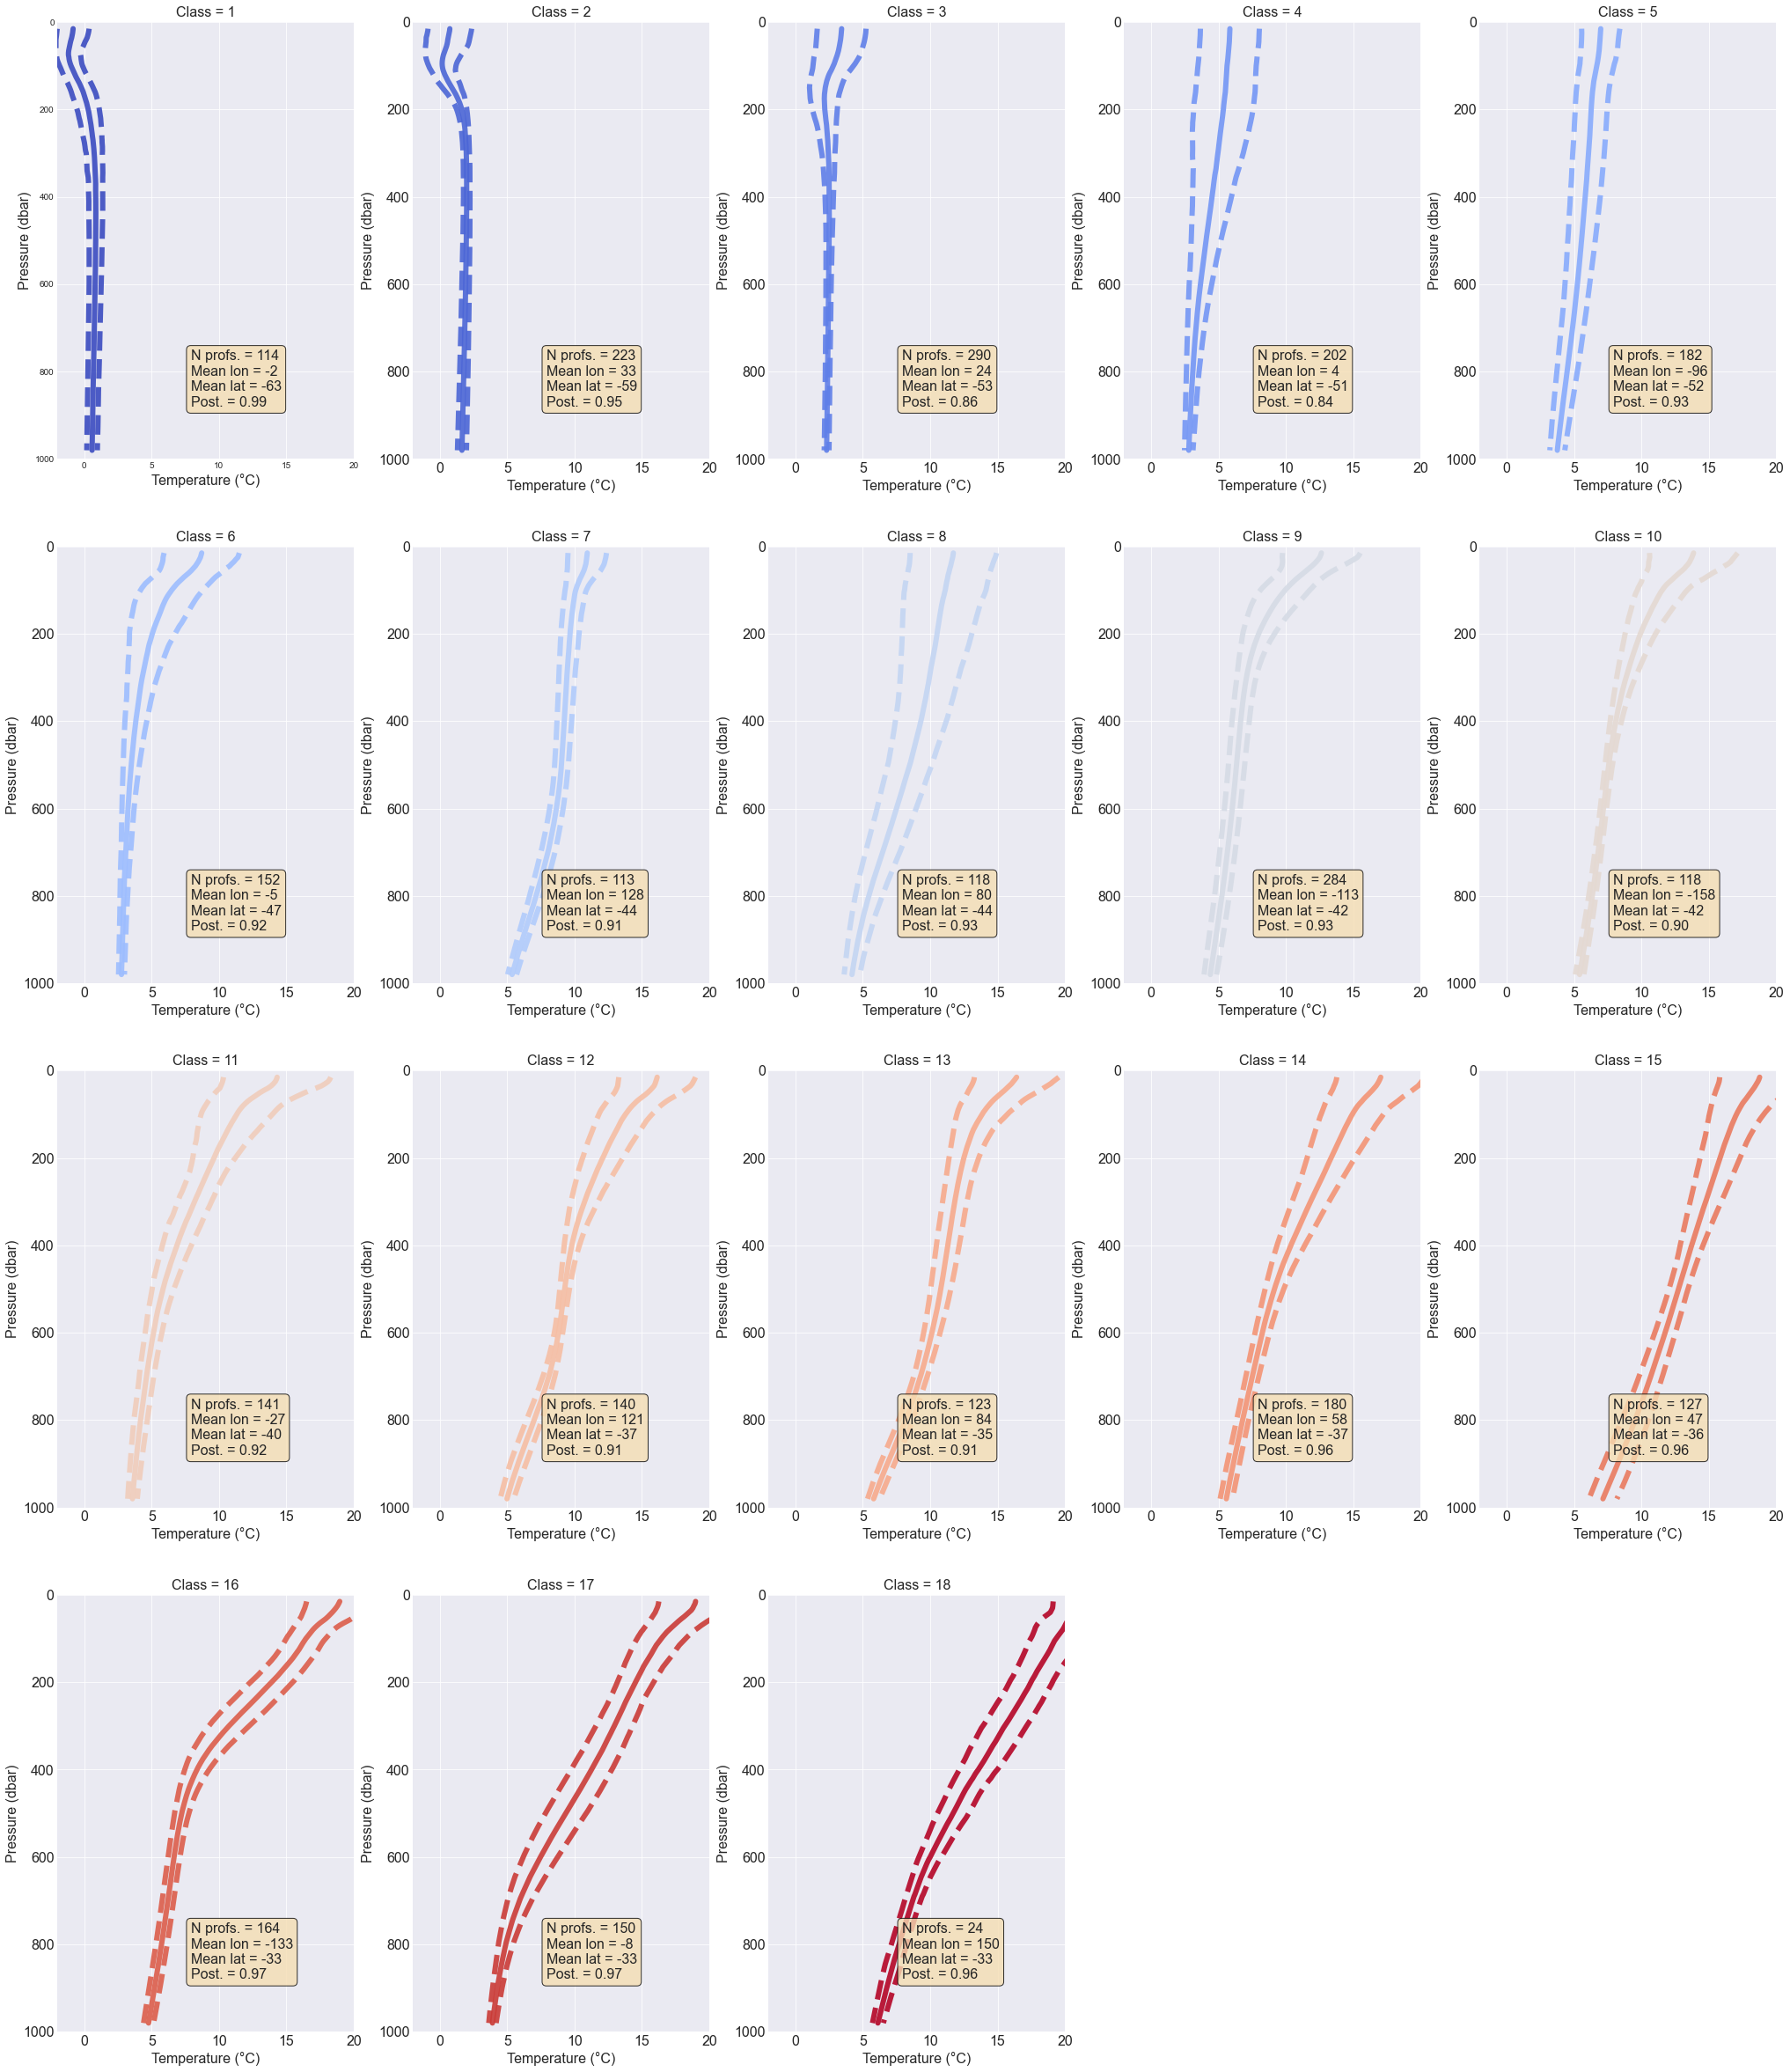

In [12]:
# initialize the figure
plt.figure(figsize=(35, 42))
plt.style.use('seaborn-darkgrid')

# create a color palette
palette = cm.coolwarm(np.linspace(0,1,n_comp))

# iterate over groups
num = 0
for nrow in range(0,n_comp):
    num += 1
    
    # extract means
    mean_lon = dfg_means.iloc[nrow,0]
    mean_lat = dfg_means.iloc[nrow,1]
    mean_maxpp = dfg_means.iloc[nrow,3]
    mean_T = dfg_means.iloc[nrow,4:].values
    
    # extract stdevs
    std_lon = dfg_stds.iloc[nrow,0]
    std_lat = dfg_stds.iloc[nrow,1]
    std_maxpp = dfg_stds.iloc[nrow,3]
    std_T = dfg_stds.iloc[nrow,4:].values
    
    # select subplot
    plt.subplot(int(np.ceil(n_comp/5)),5,num)
    plt.plot(mean_T, p, marker='', linestyle='solid', color=palette[nrow], linewidth=6.0, alpha=0.9)
    plt.plot(mean_T+std_T, p, marker='', linestyle='dashed', color=palette[nrow], linewidth=6.0, alpha=0.9)
    plt.plot(mean_T-std_T, p, marker='', linestyle='dashed', color=palette[nrow], linewidth=6.0, alpha=0.9)
    
    # custom grid and axes
    plt.ylim([0,1000])
    ax = plt.gca()
    ax.invert_yaxis() 
    plt.xlim([-2, 20])
    ax.grid(True)
    
    fs = 16 # font size
    plt.xlabel('Temperature (°C)', fontsize=fs)
    plt.ylabel('Pressure (dbar)', fontsize=fs)
    plt.title('Class = ' + str(num), fontsize=fs)
    mpl.rc('xtick', labelsize=fs)     
    mpl.rc('ytick', labelsize=fs)
    
    # text box
    textstr = '\n'.join((
        r'N profs. = %i' % (nprofs[nrow], ),
        r'Mean lon = %i' % (mean_lon, ),
        r'Mean lat = %i' % (mean_lat, ),
        r'Post. = %.2f' % (mean_maxpp, )))
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
    # place a text box in upper left in axes coords
    ax.text(0.45, 0.25, textstr, transform=ax.transAxes, fontsize=fs,
            verticalalignment='top', bbox=props)
    
plt.show()
    

In the inset text boxes above, "N profs." is the number of profiles in each class. Also shown are class mean values for longitude, latitude, and maximum posterior probability.